# Dataset ARPA Lombardia
Registrazione delle misure recuperate dal database di ARPA Lombardia.
Sono fornite a risoluzione suboraria.

La procedura si articola nei seguenti passaggi:
1. [caricamento dei dati grezzi](#caricamento-da-frammenti) e uniformazione negli schemi esposti sotto;
1. [primo quality check](#quality-check): controllo errori di consistenza nella singola serie e nelle coppie di serie della stessa stazione;
1. [overview disponibilità dati](#overview-disponibilità-dati): plot che mostrano la disponibilità temporale e spaziale di serie;
1. [merging](#merging) del dataset con SCIA.

## Data model
### Metadati
| station_id | station_name | network | state | lon    | lat    | elevation | dataset_id | original_id |
|------------|--------------|---------|-------|--------|--------|-----------|------------|-------------|
| utf8()     | utf8()       | utf8()  | utf8()|double()|double()| double()  | utf8()     | utf8()      |
| pkey       | obs          | obs     | obs   | obs    | obs    | obs       | fkey       | obs         |

I metadati delle stazioni che non rientrano nelle tabelle elencate vanno in una tabella "extra" collegata tramite "station_id".

### Dati
|station_id|date|value|merged|variable|
|----------|----|-----|------|--------|
|utf8() |date()|double()|bool()|utf8()|
| fkey     |obs | obs | obs  | obs    |

Note:
- `merged` indica se il valore in riga è il risultato di un merge.


In [24]:
dataset_id <- "ARPALombardia"
state <- "Lombardia"


In [35]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(zeallot, warn.conflicts = FALSE)
library(stringr, warn.conflicts = FALSE)
options(repr.plot.width = 9, repr.plot.res = 300)

source(str_glue("notebooks/integrazioni_regionali/{str_to_lower(state)}/procedures/load_daily.R"))
source(str_glue("notebooks/integrazioni_regionali/{str_to_lower(state)}/procedures/match_taggers.R"))
source("notebooks/integrazioni_regionali/procedure/common_steps.R")
source("notebooks/integrazioni_regionali/procedure/checkpoint.R")
source("notebooks/integrazioni_regionali/procedure/tools.R")
source("src/database/tools.R")
source("src/load/ITA.R")

first_date <- as.Date("2000-01-01")
last_date <- as.Date("2022-12-31")
state_boundaries <- load.italian_boundaries("state") |> filter(shapeName == state)


## Caricamento da frammenti
Dati giornalieri come forniti dall'ente, in formato tabella Arrow


In [3]:
daily_dataset <- load_daily_data.arpal() |> prepare_daily_data(first_date, last_date)
checkpoint_database(daily_dataset$database, dataset_id, "raw")
write_extra_metadata(daily_dataset$extra_meta, dataset_id, provisional = FALSE)
rm(daily_dataset)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,1855883,99.2,3403471,181.8,NA,3403471,181.8
Vcells,5890412,45.0,24479269,186.8,16384,24479269,186.8


## Quality check
Controllo gross errors, dati ripetuti, T_MIN >= T_MAX, serie intere

In [4]:
raw_database <- open_checkpoint(dataset_id, "raw")
qc_database <- qc1(raw_database, stop_on_error = TRUE)

checkpoint_database(qc_database, dataset_id, "qc1")
rm(raw_database)
rm(qc_database)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,1978438,105.7,3403471,181.8,NA,3403471,181.8
Vcells,6098086,46.6,62881492,479.8,16384,78598472,599.7


## Overview disponibilità dati
Grafici che mostrano la disponibilità di serie mese per mese e sul territorio

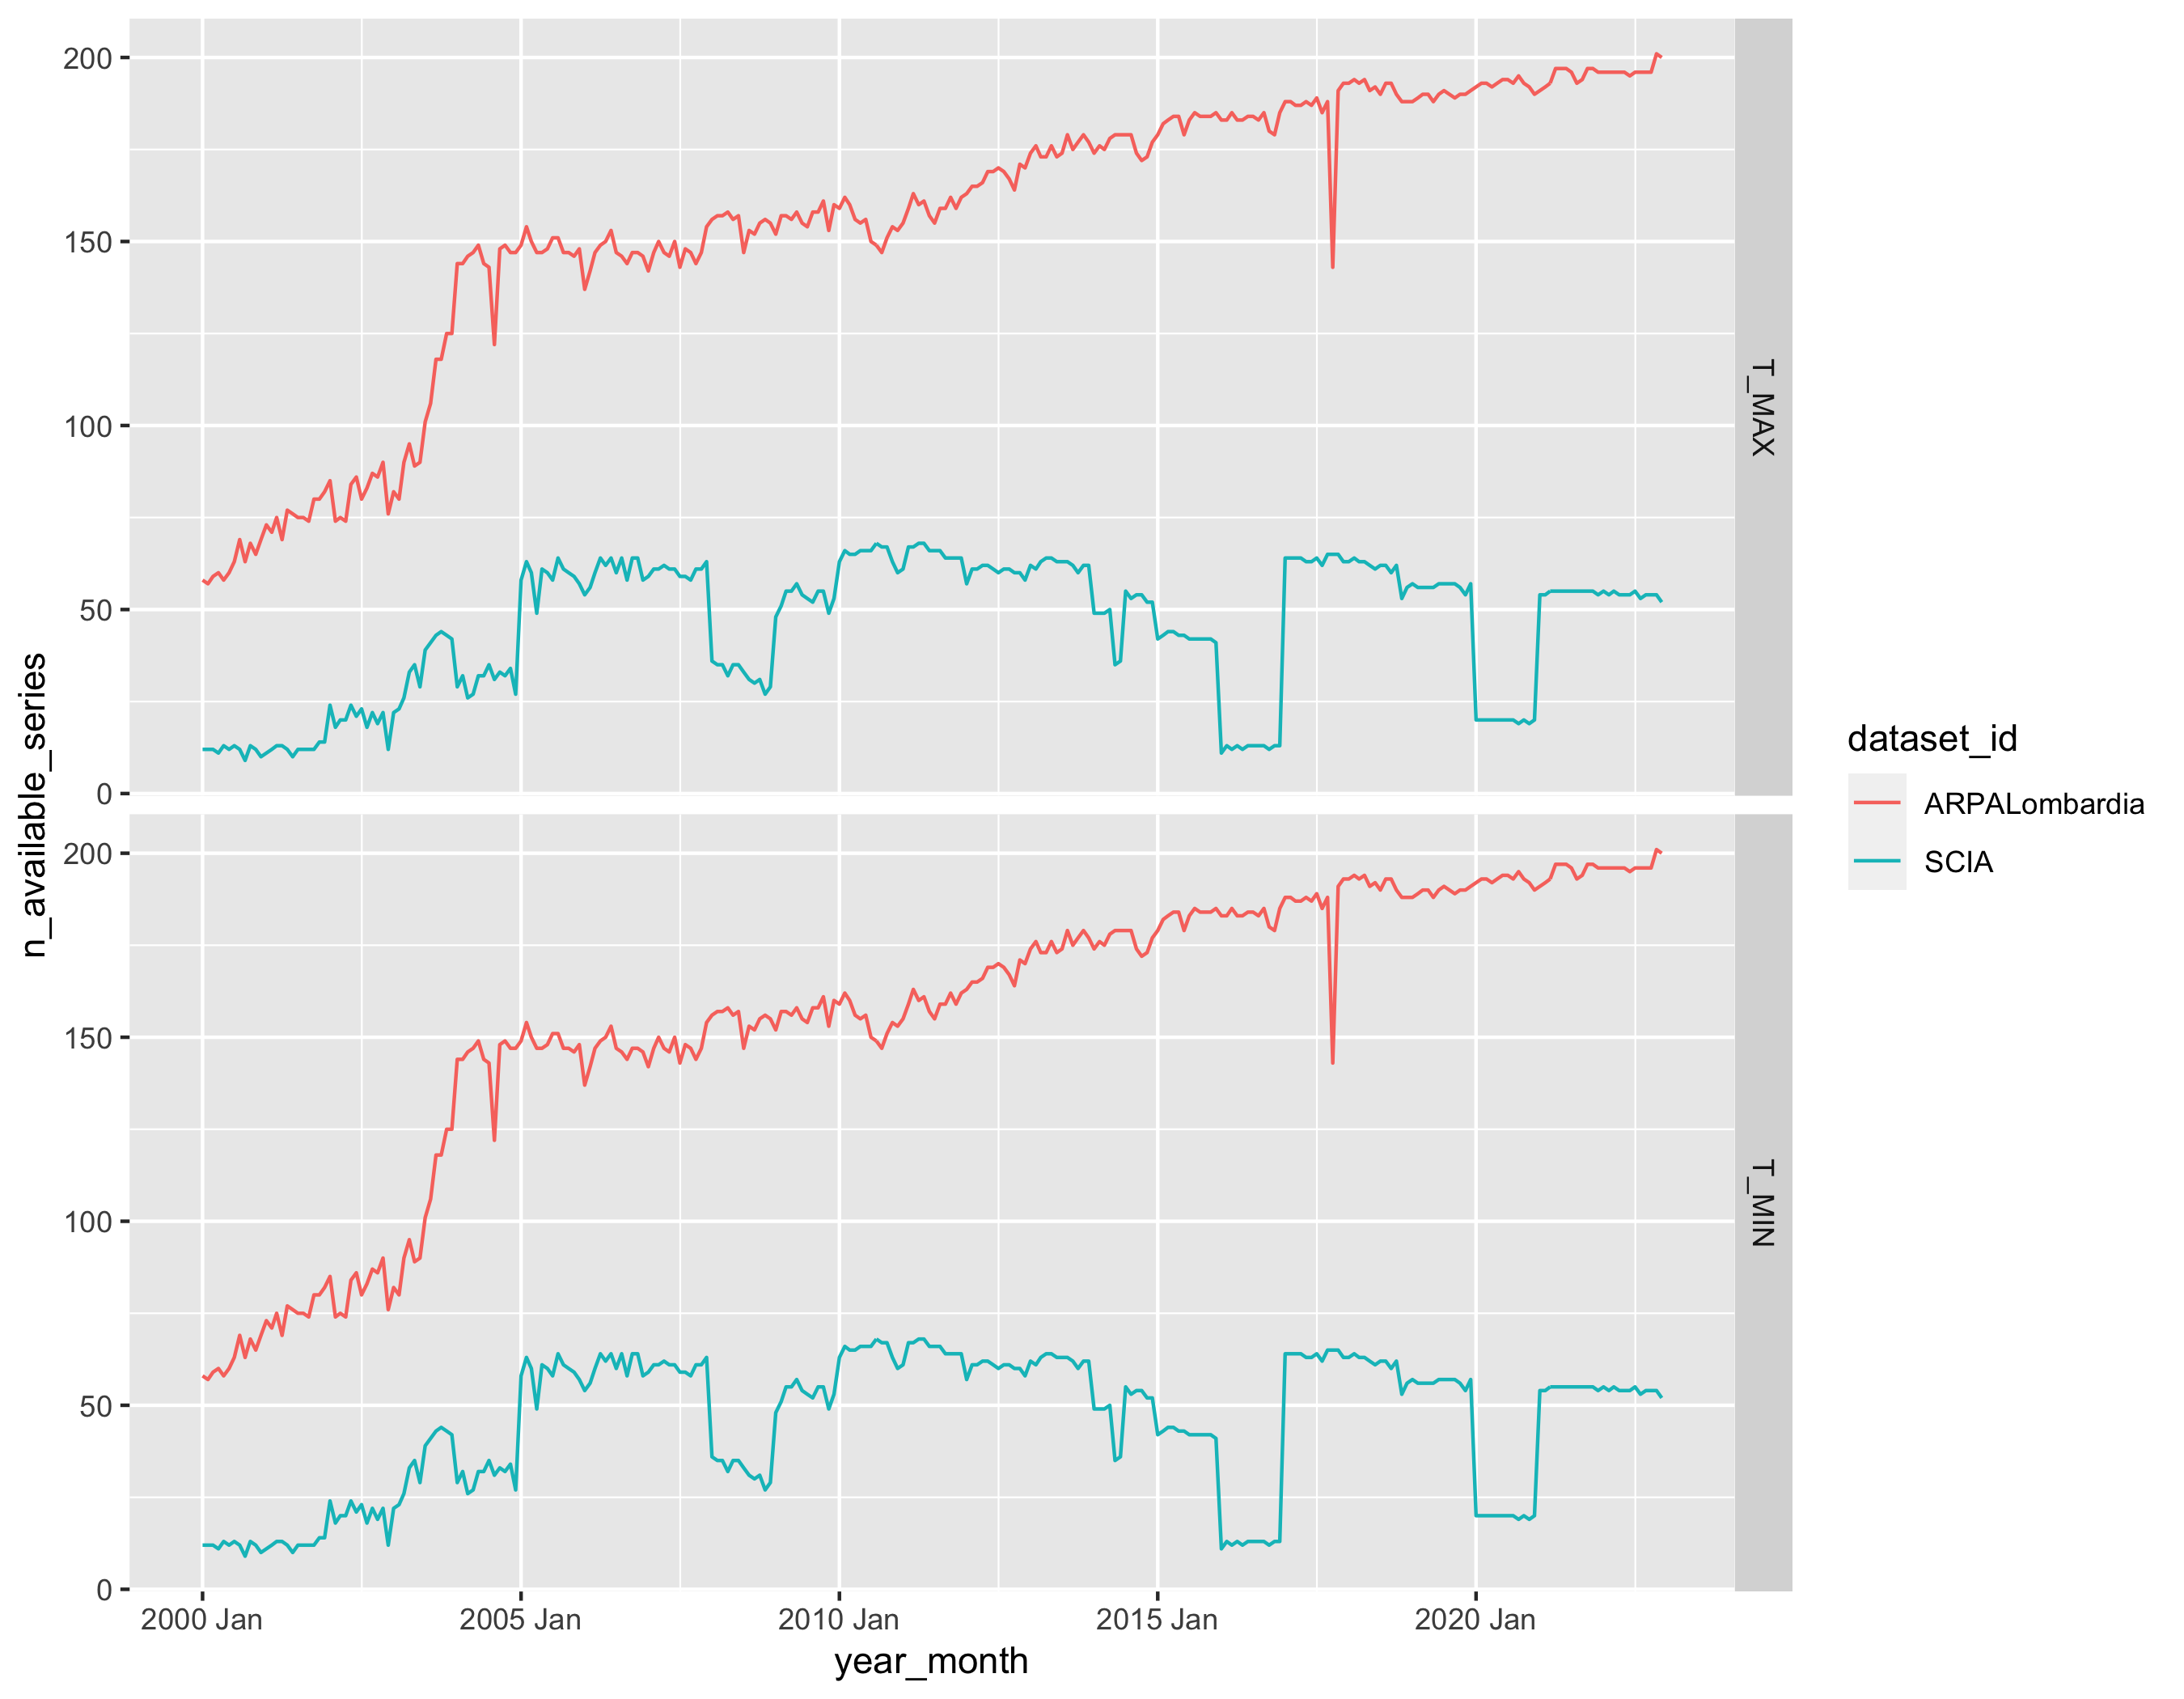

In [5]:
qc_database <- open_checkpoint(dataset_id, "qc1")
c(p, ymonthly_avail) %<-% ymonthly_availabilities(qc_database,
    against = "SCIA",
    region = state_boundaries,
    chkp_id = "qc1",
    start_date = first_date,
    end_date = last_date
)
p


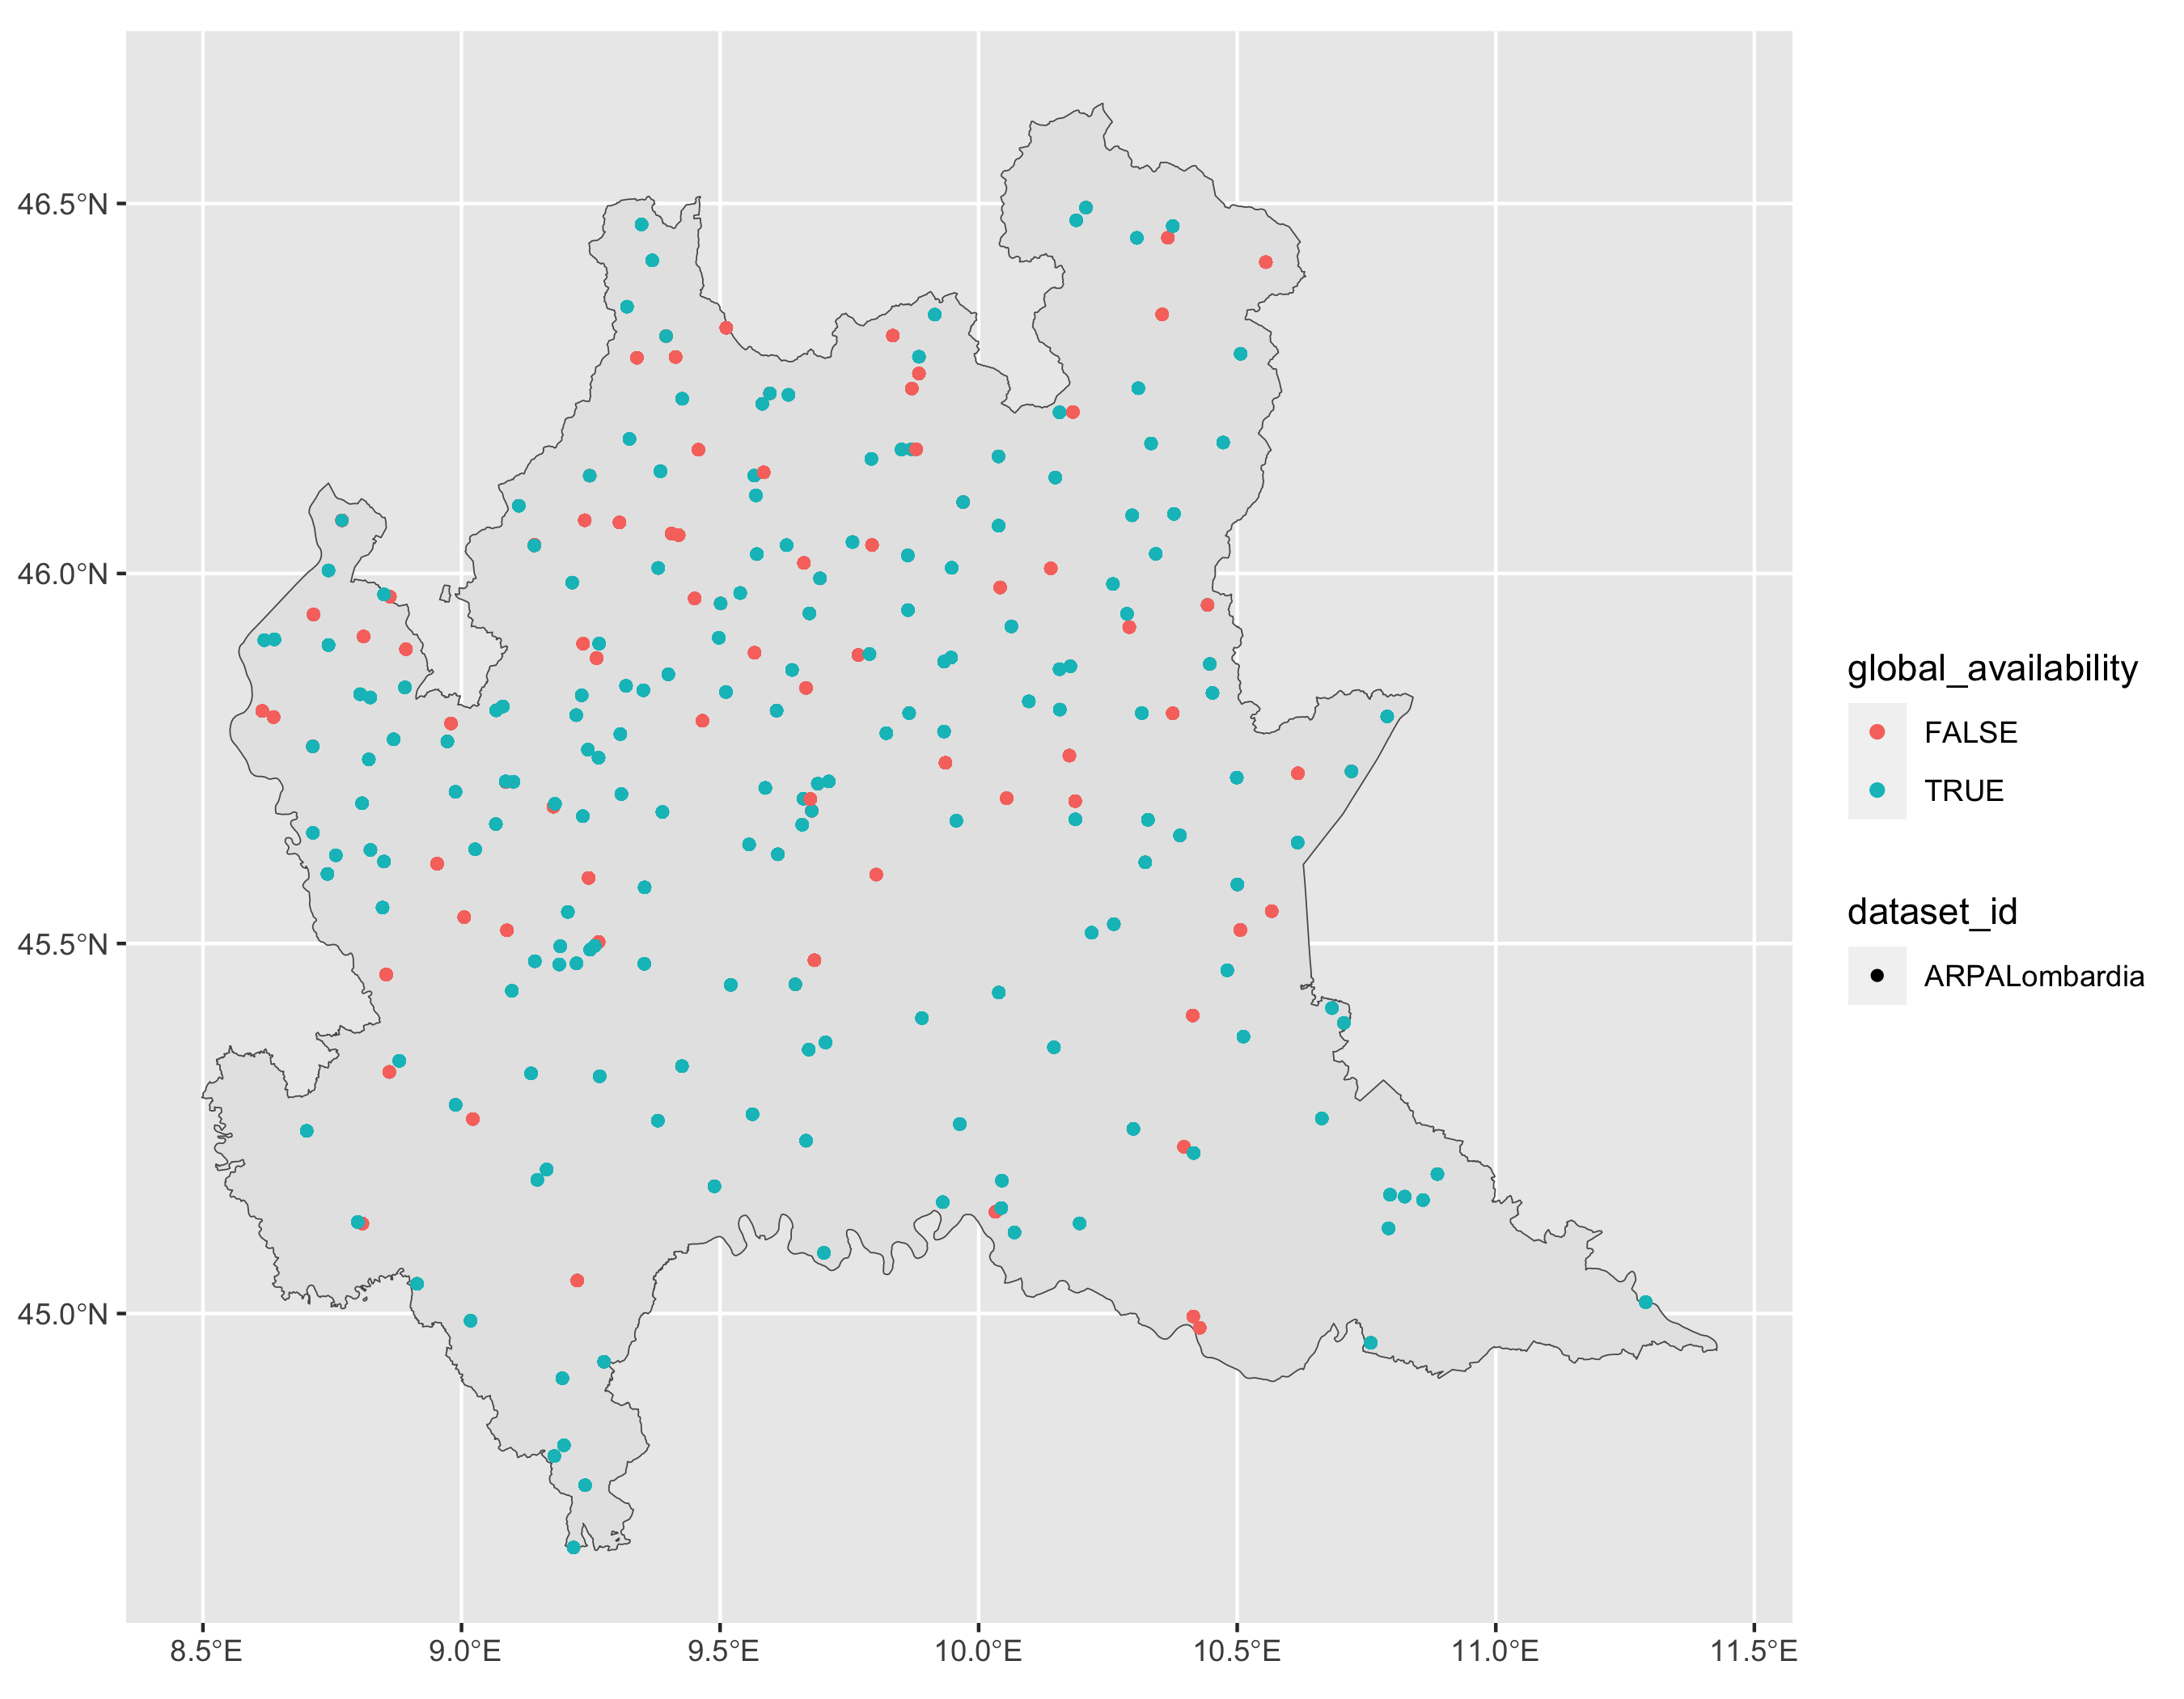

In [6]:
c(p, climats) %<-% spatial_availabilities(ymonthly_avail |> filter(dataset_id == !!dataset_id), qc_database$meta, state_boundaries)
p


In [7]:
rm(qc_database)
rm(ymonthly_avail)
rm(climats)
rm(p)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2245991,120.0,4406612,235.4,NA,4406612,235.4
Vcells,4743167,36.2,150846016,1150.9,16384,188555063,1438.6


## Merging
Gap-filling con altri dataset

### Match stazioni
Partendo dal file di analisi appena scritto preparo dei filtri che categorizzino il match.

Le possibilità sono:
- `tag_same_station`: il match indica una stessa stazione;
- `tag_unusable`: il match è inutilizzabile;
- `tag_pairable`: il match indica che le stazioni sono utilizzabili per fare gap-filling.

Può essere che un match sia sulla stessa stazione ma che sia inutilizzabile; `tag_unusable` e `tag_pairable` invece si dovrebbero escludere vicendevolmente.

In [8]:
qc_state <- open_checkpoint(dataset_id, "qc1")
qc_scia <- open_checkpoint("SCIA", "qc1") |> filter_checkpoint_inside(state_boundaries)
analysis_results <- perform_analysis(
    qc_state,
    qc_scia,
    dist_km = 6,
    first_date,
    last_date,
    str_to_lower(state)
)
rm(qc_state)
rm(qc_scia)
gc()


Data prepared. Launching analysis...

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2331106,124.5,4406612,235.4,NA,4406612,235.4
Vcells,9080640,69.3,120676813,920.7,16384,188555063,1438.6


In [17]:
analysis_results <- tag_analysis(analysis_results, list("same_station" = tag_same_station, "unusable" = tag_unusable))
analysis_results$analysis |>
        group_by(same_station, unusable) |>
        tally()
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.x) |>
        tally() |>
        filter(n != 2L)
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.y) |>
        tally() |>
        filter(n != 2L)


same_station,unusable,n
<lgl>,<lgl>,<int>
FALSE,FALSE,73
FALSE,TRUE,125
TRUE,FALSE,176
TRUE,TRUE,26


station_id.x,n
<chr>,<int>
1e2cb4c4b65b7a7d6d698d330cde714d,4
34b688686a432361f4d0e35cf8107d09,4
5e2f2818ad8e6d3eecf3d6fca544ab97,4
62e053d4decc0986807ad91cc2104004,4
6ecea96bf4171416f62f1c7ca3a1c697,4
7465b33434b1b71c6af9d8c606547725,4
90c5e58b4b6a1c9cf441c565937c2fd2,4
ce1699bcb734dfeeff6549870533a72c,4
d70bc9e8165c0435a560c95a85ddcca3,4


station_id.y,n
<chr>,<int>
0490545aff317e407e42651db2883309,4
1490fc5f5e8c61cfe70dfb4a77505a08,4
2e872ddd60da3123cb2eb8ea676f0483,4
32fc015b37b19a851d2eba0a63bccead,4
3b85345f04b80b8da638666f8973d478,4
53fed29cdb67678d908181543241b840,4
5489e1ae6d694605eaddfa50ce46af7c,4
5bb39c275880740997e94ec269dc185a,4
5eba8ebb80d64511eeff2ec26b96a10d,4


In [18]:
# All corrections are below 2°C
combination_results <- build_combined_database(analysis_results, use_corrections = TRUE, checks = TRUE, test_bounds = 2, NULL)
checkpoint_database(combination_results$database, dataset_id, "merged_scia")
save_match_list(combination_results$match_list, dataset_id, "merged_scia")
rm(combination_results)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2368260,126.5,4406612,235.4,NA,4406612,235.4
Vcells,10386849,79.3,86163700,657.4,16384,188555063,1438.6


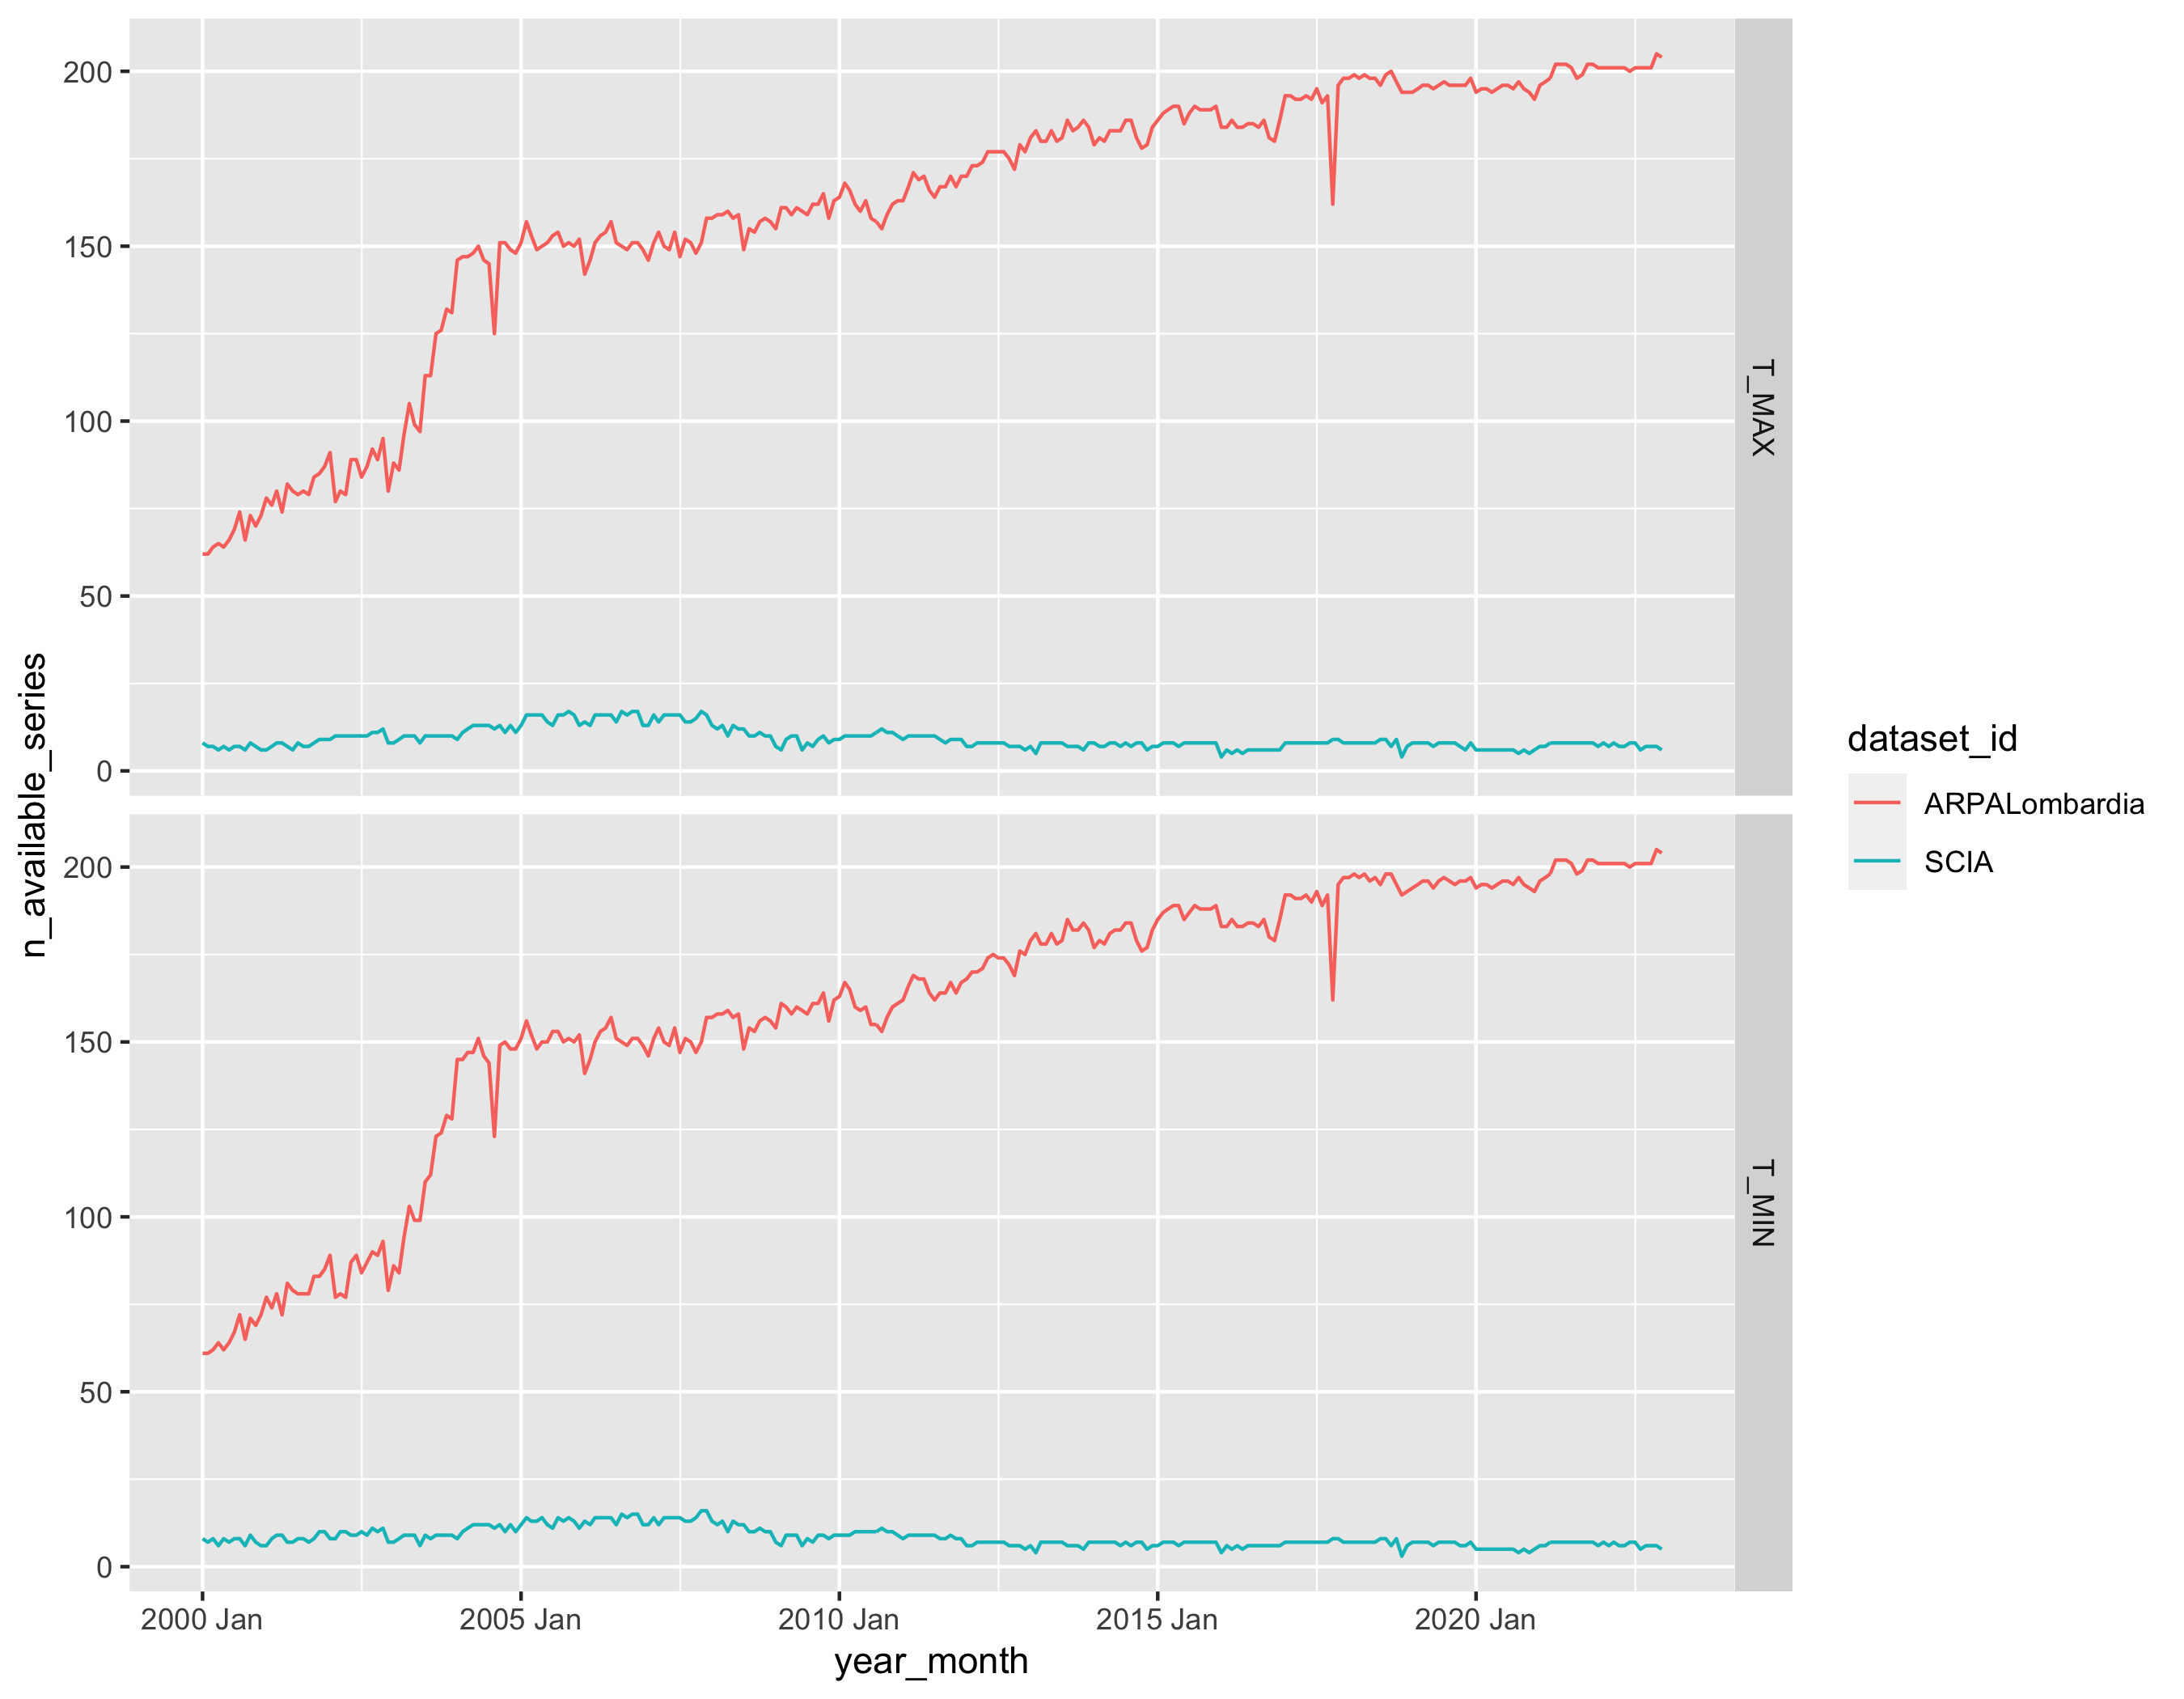

In [19]:
combined_database <- open_checkpoint(dataset_id, "merged_scia")
c(p, ymonthly_avail) %<-% ymonthly_availabilities(combined_database,
    start_date = first_date,
    end_date = last_date
)
p


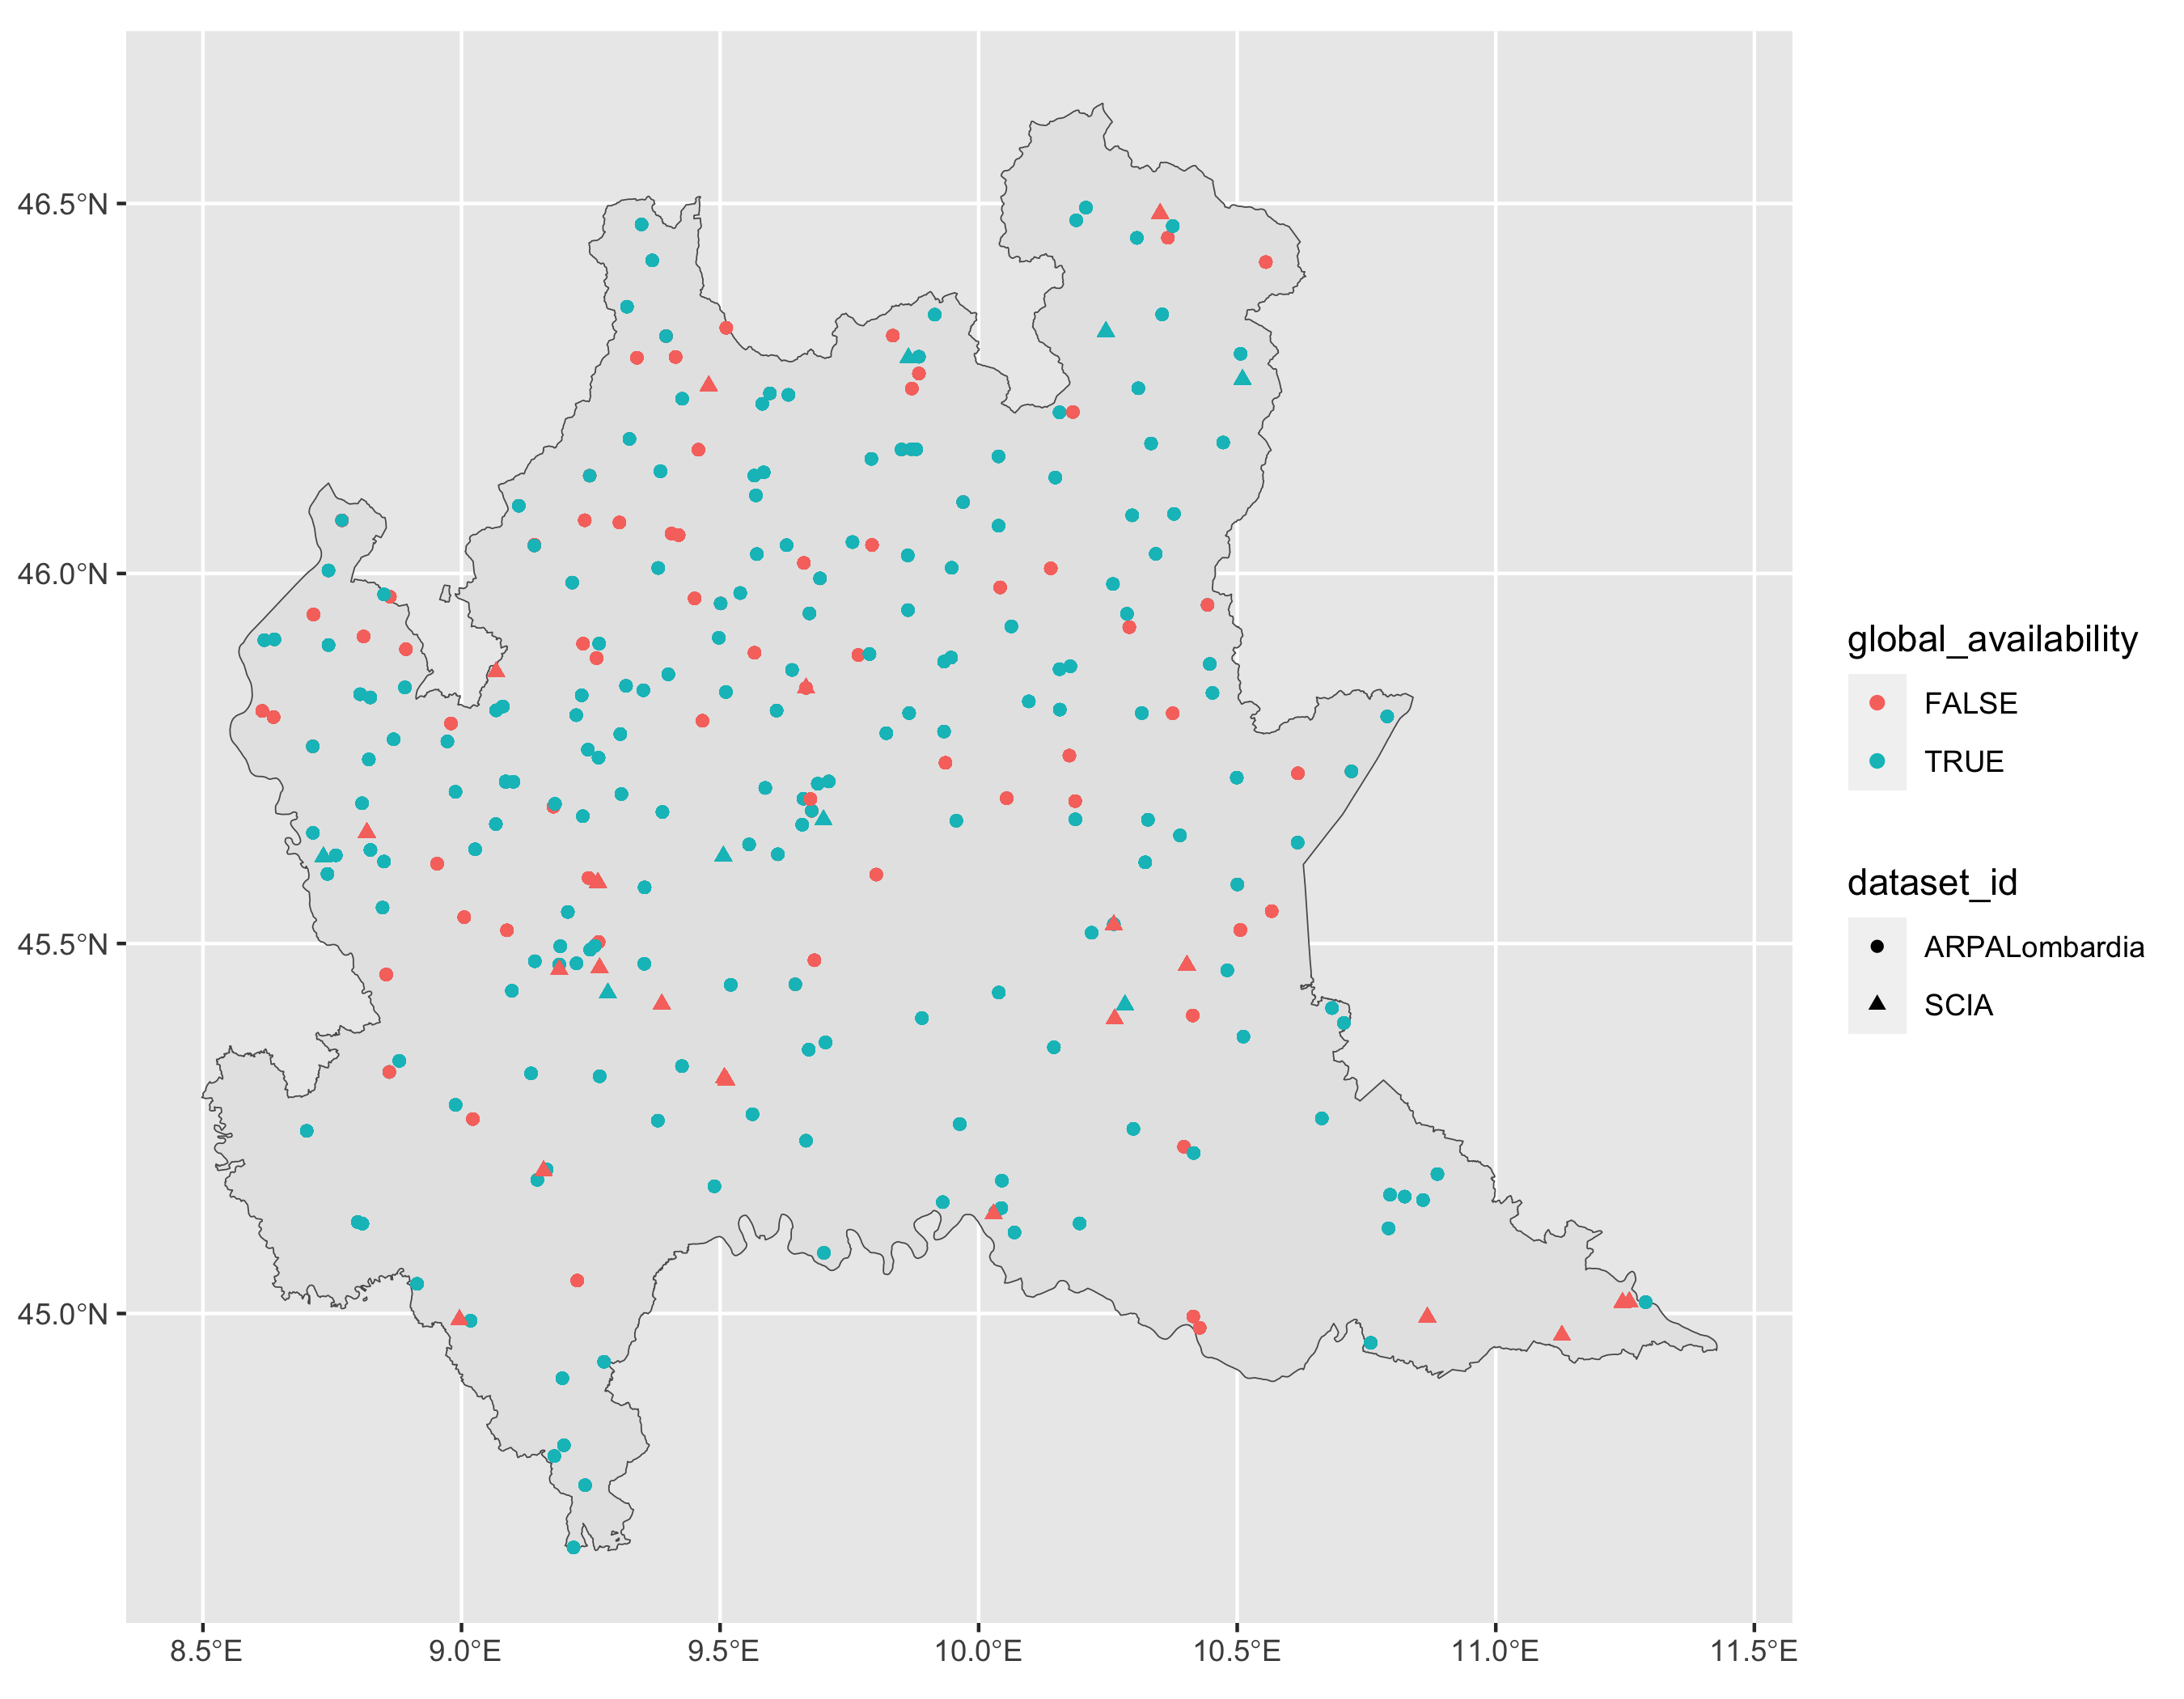

In [20]:
c(p, climats) %<-% spatial_availabilities(
    ymonthly_avail,
    combined_database$meta,
    state_boundaries
)
p


In [21]:
rm(ymonthly_avail)
rm(climats)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2366906,126.5,4406612,235.4,NA,4406612,235.4
Vcells,9257730,70.7,126125313,962.3,16384,188555063,1438.6


### Merge interno

In [26]:
merged_scia <- open_checkpoint(dataset_id, "merged_scia")
analysis_results <- perform_analysis_single(
    merged_scia,
    dist_km = 6,
    first_date,
    last_date,
    file.path(str_to_lower(state), "internal.xlsx")
)
rm(merged_scia)
gc()


Data prepared. Launching analysis...

Warning message in rm(qc_state):
"oggetto 'qc_state' non trovato"
Warning message in rm(qc_scia):
"oggetto 'qc_scia' non trovato"


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2372183,126.7,5327934,284.6,NA,5327934,284.6
Vcells,8535063,65.2,174588592,1332.1,16384,218235739,1665.1


In [36]:
analysis_results <- tag_analysis(analysis_results, list("same_station" = tag_same_station_internal, "unusable" = tag_unusable_internal))
analysis_results$analysis |>
        group_by(same_station, unusable) |>
        tally()
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.x) |>
        tally() |>
        filter(n != 2L)
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.y) |>
        tally() |>
        filter(n != 2L)


same_station,unusable,n
<lgl>,<lgl>,<int>
FALSE,FALSE,265
FALSE,TRUE,117
TRUE,FALSE,316
TRUE,TRUE,74


station_id.x,n
<chr>,<int>
04962020bb979608b1cc19a46daf990b,4
0cab311fb398597f96cceec0e1e98504,8
102b6d291c04e06f0ecda469a654faf0,1
11aa13cdc7c3f53c81f94bef9c1a3de9,4
1e2cb4c4b65b7a7d6d698d330cde714d,5
1ff971f2d14aa5d34ea1606401aa0e53,4
3425897445c4d995d60dc3fa3ba769bd,8
34b688686a432361f4d0e35cf8107d09,3
509c59aceb5c927288441e9ea999966b,13


station_id.y,n
<chr>,<int>
04962020bb979608b1cc19a46daf990b,4
0cab311fb398597f96cceec0e1e98504,8
102b6d291c04e06f0ecda469a654faf0,1
11aa13cdc7c3f53c81f94bef9c1a3de9,4
1e2cb4c4b65b7a7d6d698d330cde714d,5
1ff971f2d14aa5d34ea1606401aa0e53,4
3425897445c4d995d60dc3fa3ba769bd,8
34b688686a432361f4d0e35cf8107d09,3
509c59aceb5c927288441e9ea999966b,13


In [39]:
merge_left_if <- function(analysis) {
    analysis |> filter(valid_days.x >= valid_days.y)
}

In [40]:
combination_results <- build_combined_database(analysis_results, use_corrections = TRUE, checks = TRUE, test_bounds = NULL, merge_left_if)
checkpoint_database(combination_results$database, dataset_id, "merged")
save_match_list(combination_results$match_list, dataset_id, "merged")
rm(combination_results)
gc()

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2388870,127.6,5327934,284.6,NA,5327934,284.6
Vcells,9353138,71.4,89389360,682.0,16384,218235739,1665.1


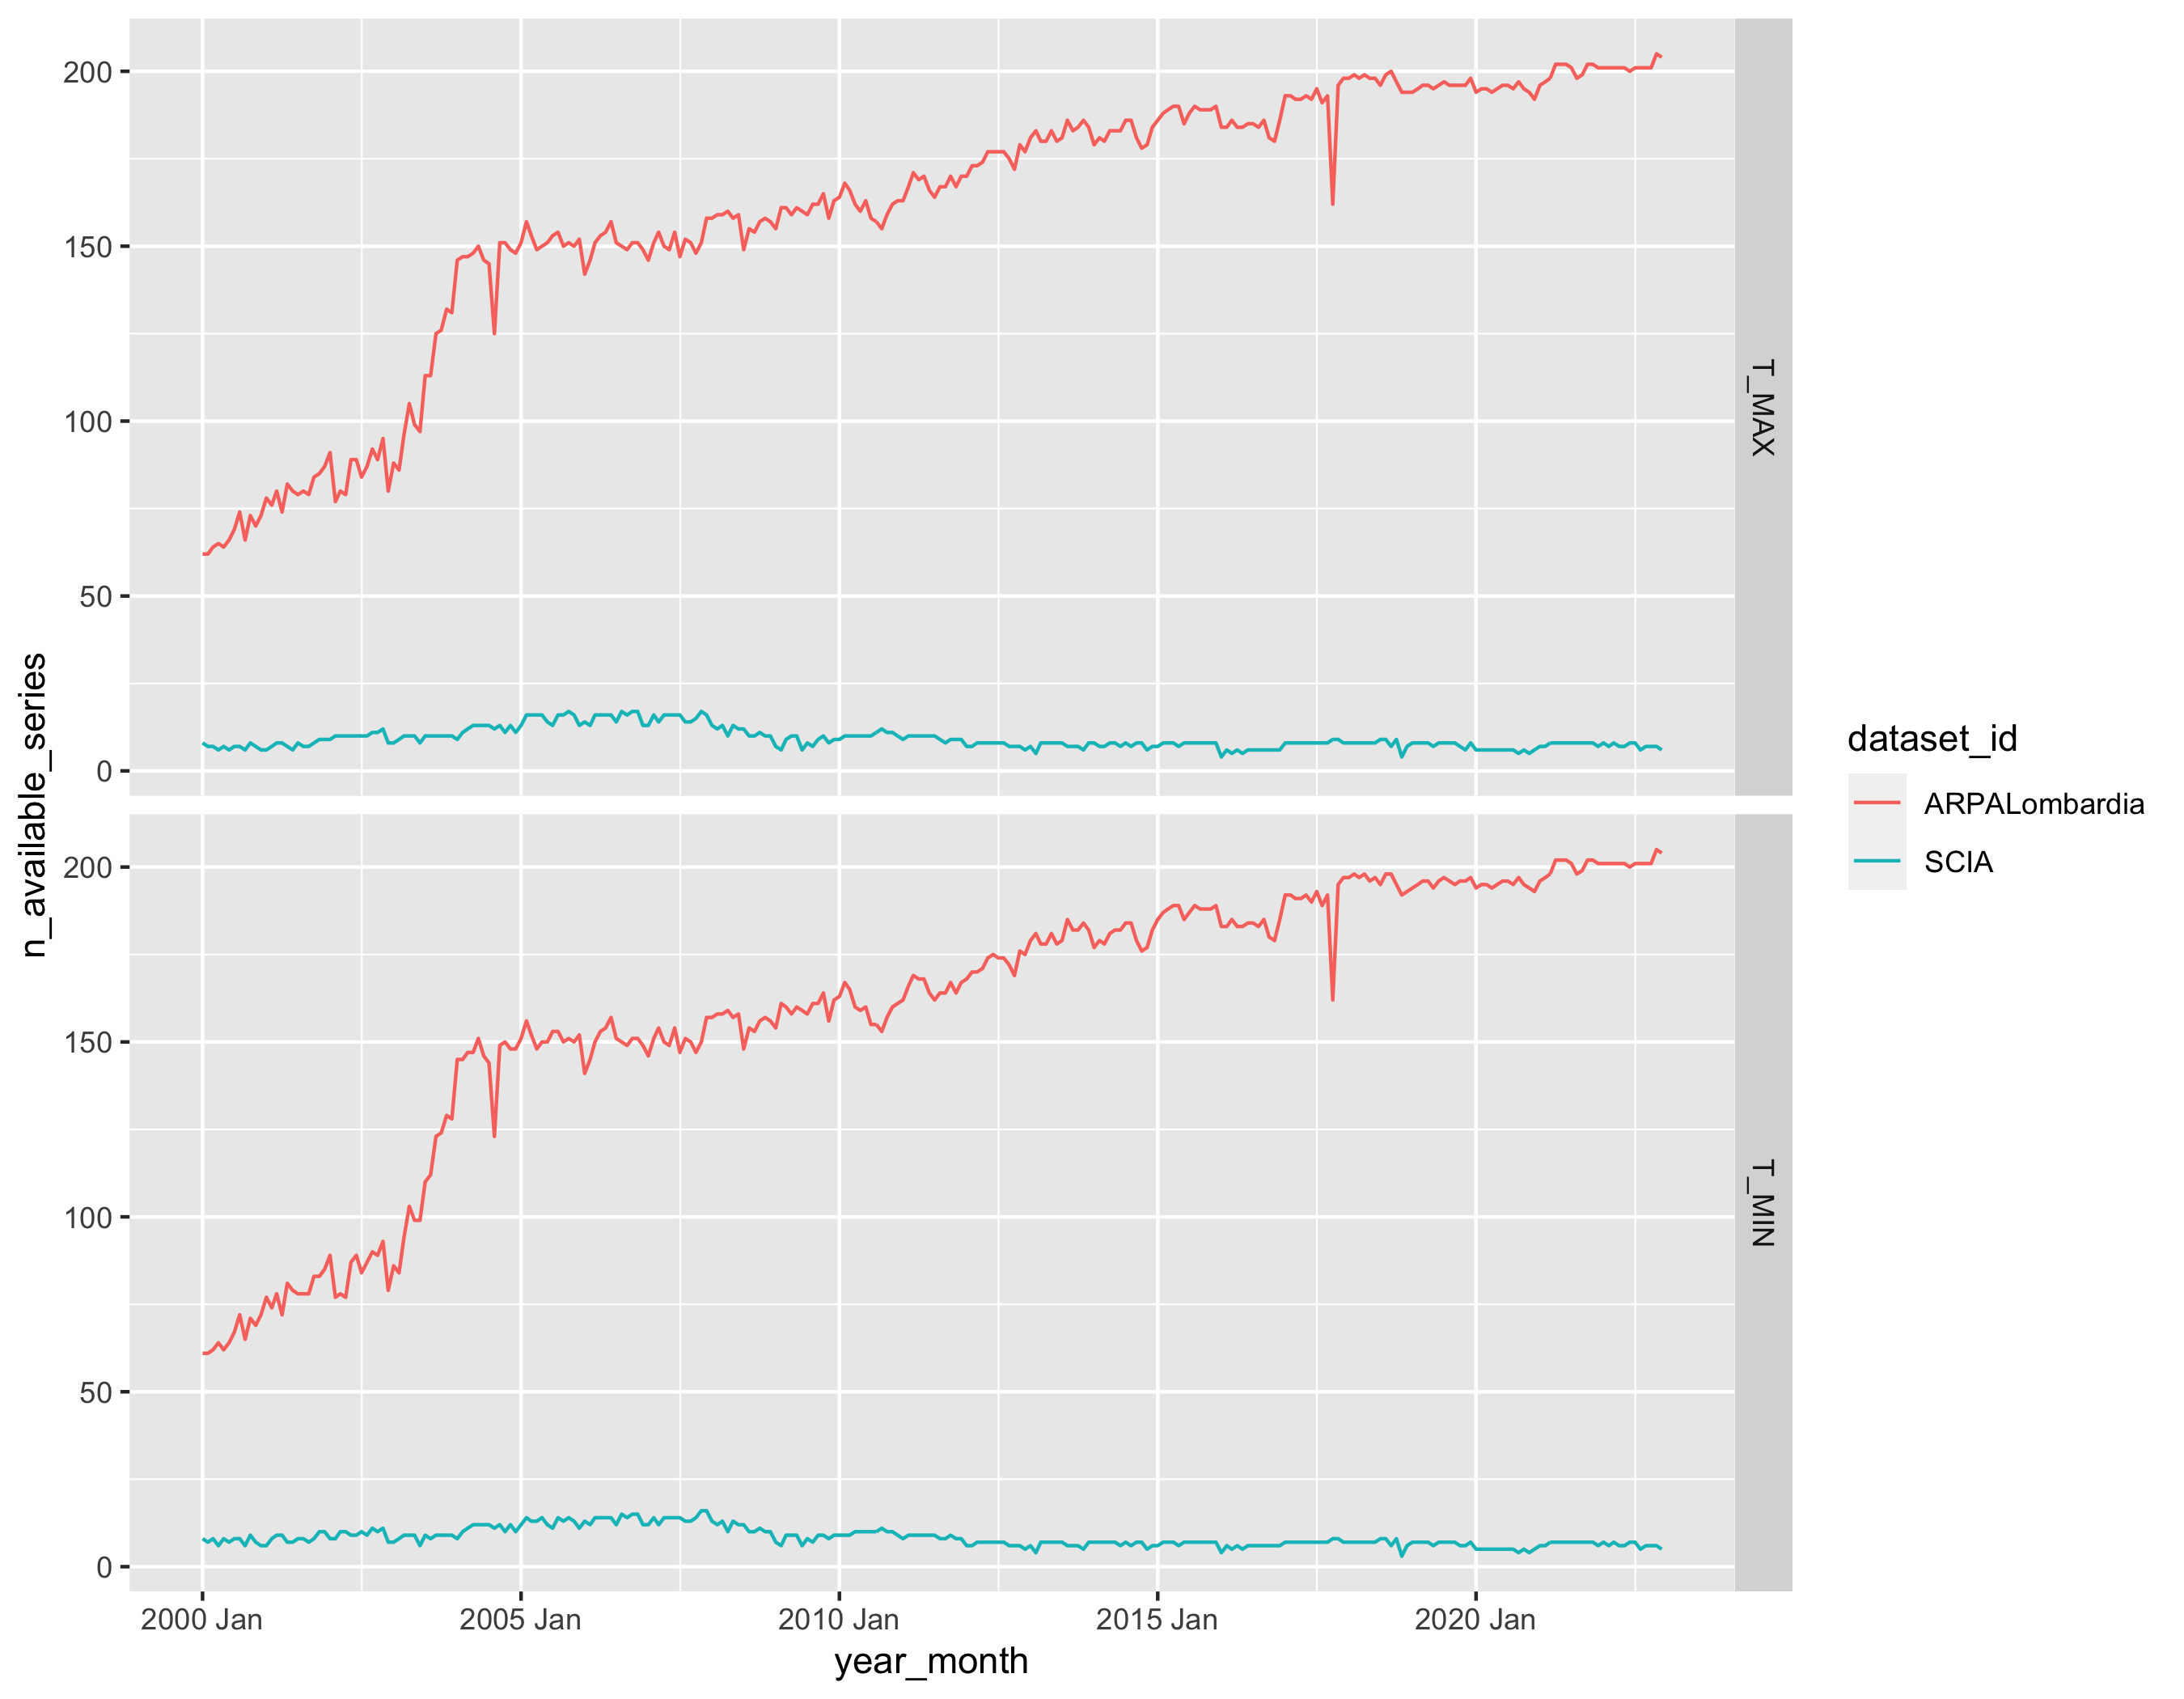

In [42]:
combined_database <- open_checkpoint(dataset_id, "merged_scia")
c(p, ymonthly_avail) %<-% ymonthly_availabilities(combined_database,
    start_date = first_date,
    end_date = last_date
)
p

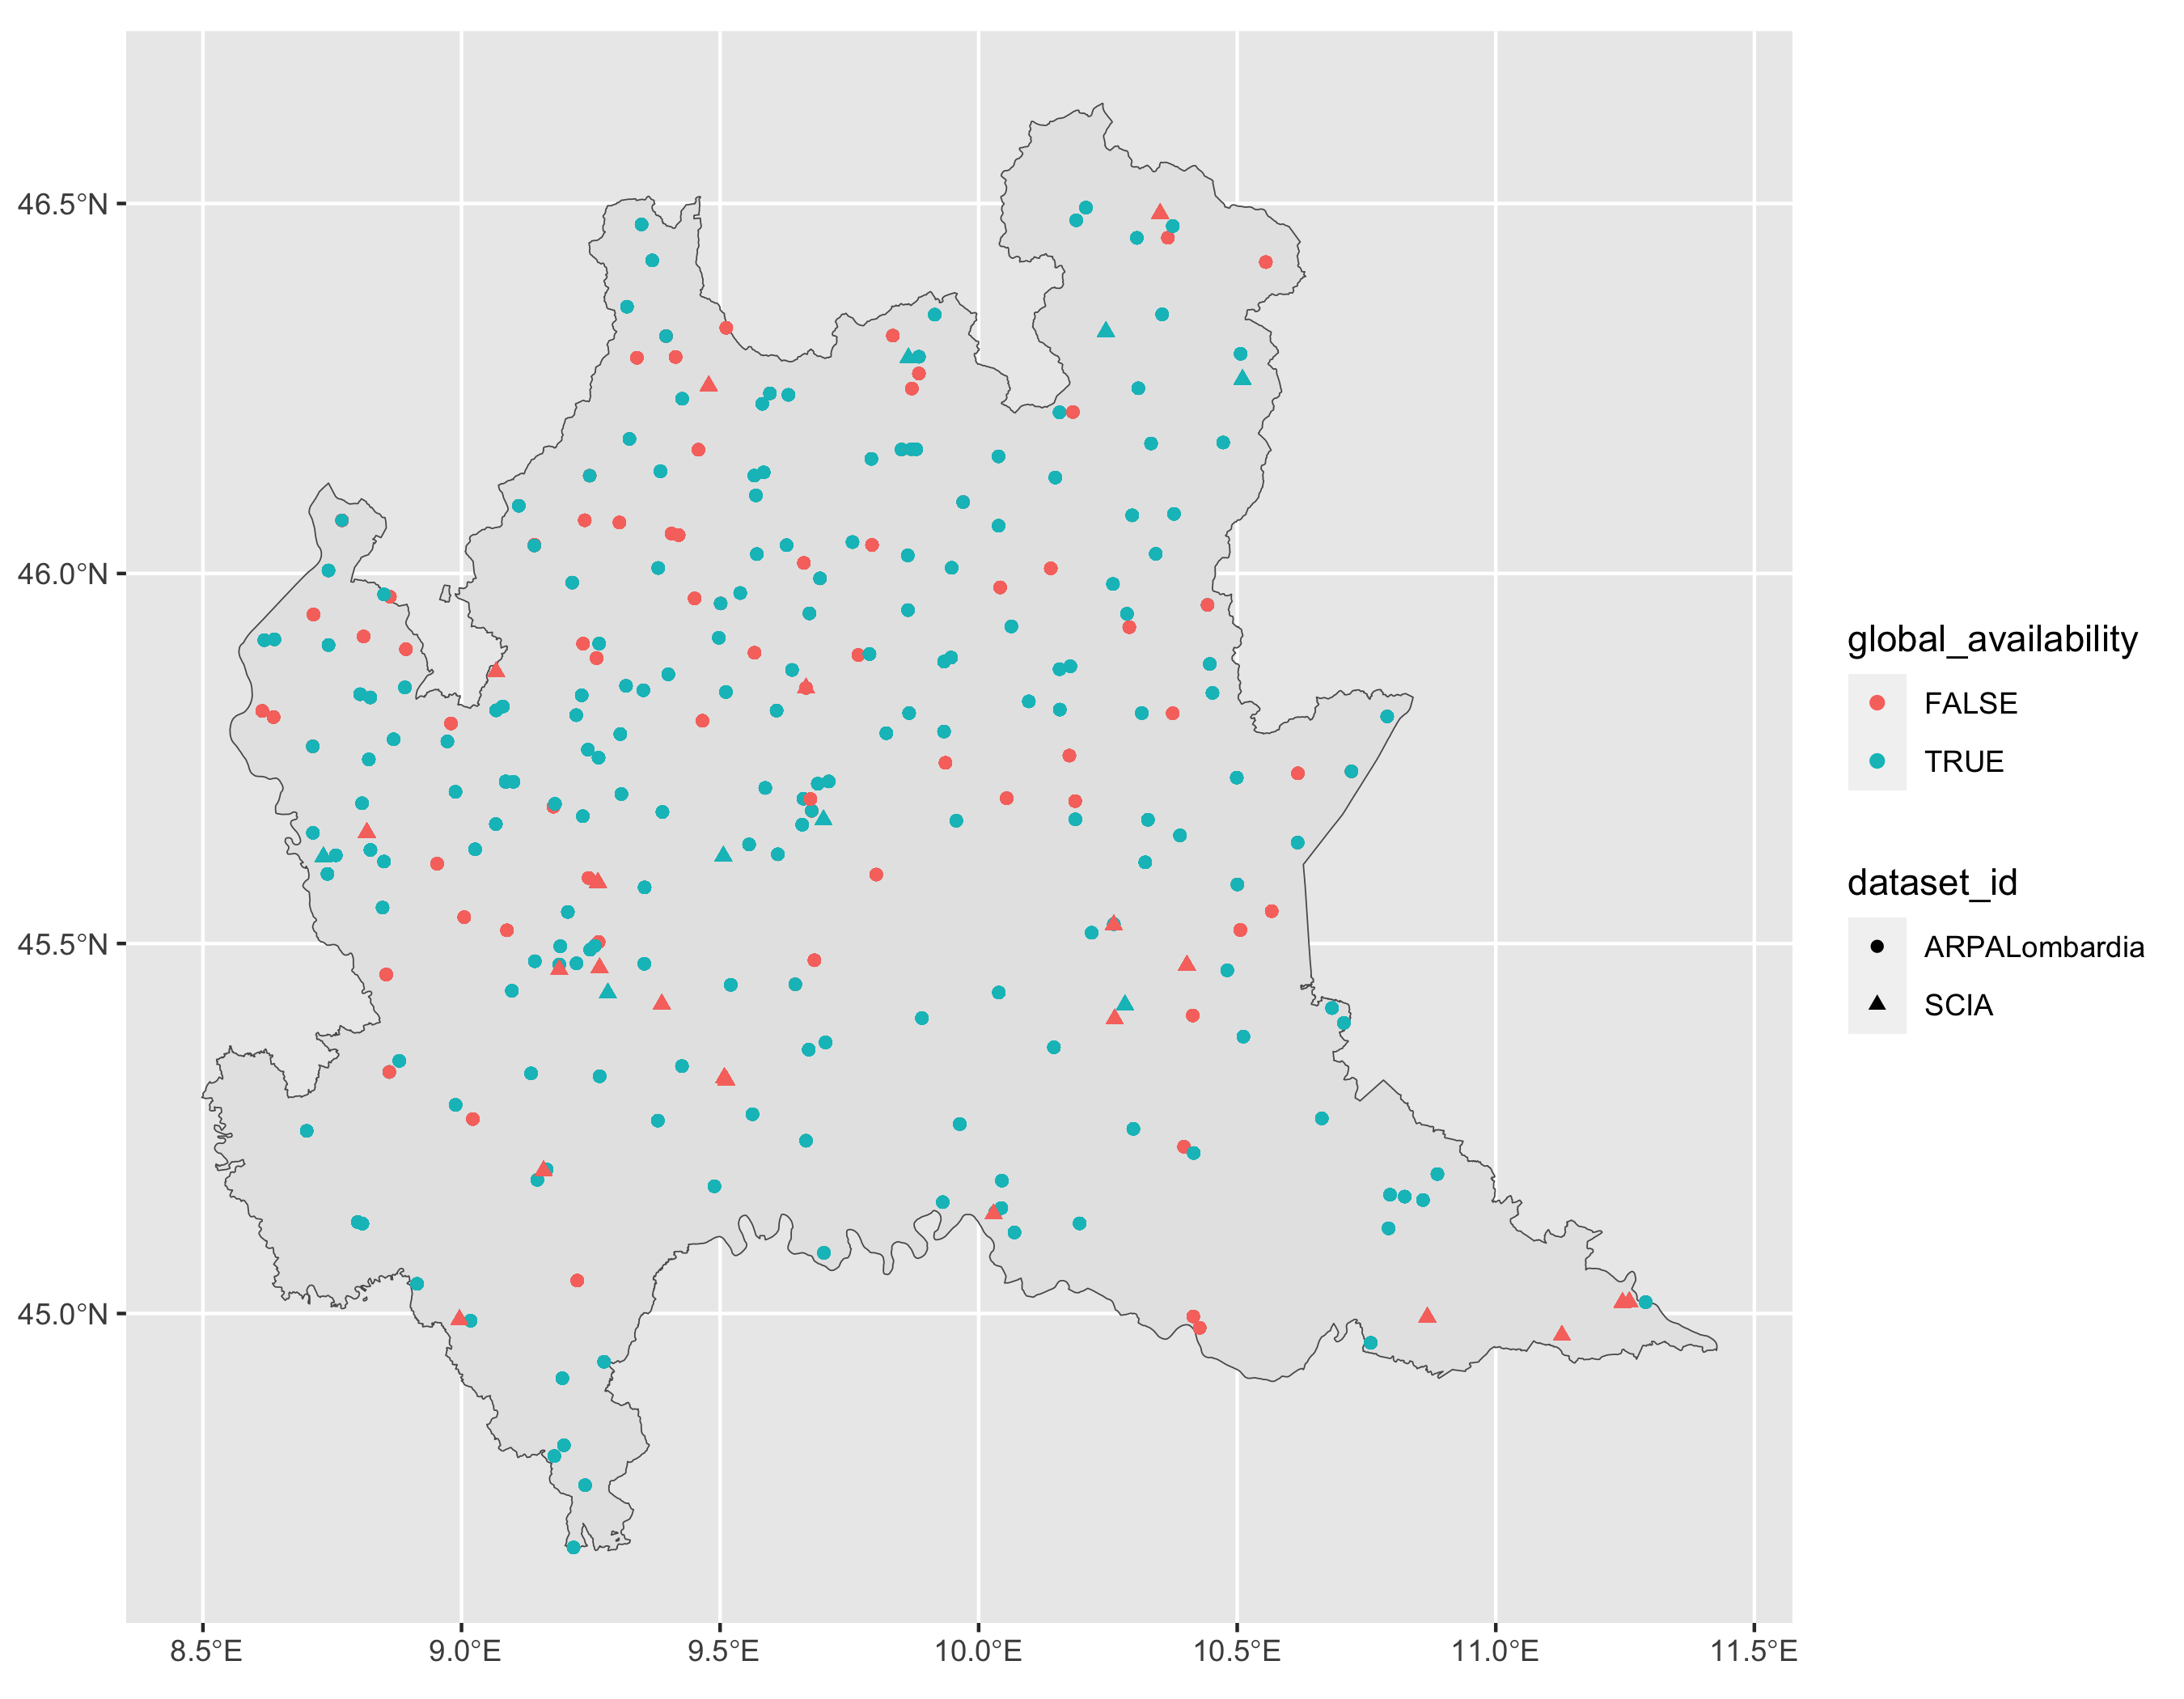

In [43]:
c(p, climats) %<-% spatial_availabilities(
    ymonthly_avail,
    combined_database$meta,
    state_boundaries
)
p


In [41]:
source("notebooks/integrazioni_regionali/procedure/checkpoint.R")
open_checkpoint(dataset_id, "merged")$data |>
    distinct(station_id, variable) |>
    compute() |>
    nrow()


[1] 472

In [ ]:
source("src/pairing/displaying.R")
source("notebooks/integrazioni_regionali/procedure/checkpoint.R")
open_checkpoint("ARPALombardia", "merged") |>
    launch_leaflet()
